In [ ]:
# 任意位置横盘测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, gamma=0.1, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
# MACD robust 任意位置横盘测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_hl_MACD_robust(df, filename, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, gamma=0.1, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_hl_MACD_robust(df, filename, fig_start_date='2019-7', fig_end_date='2021-3')

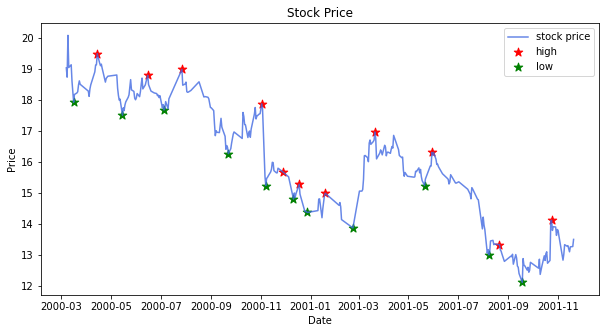

In [7]:
z,zz = hl.find_hl_MACD_robust(df, filename, fig_start_date='2000-1', fig_end_date='2001-12')

In [11]:
import pandas as pd
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_hl_MACD_robust(df, filename, draw=False, fig_start_date='2019-7', fig_end_date='2021-3')
hd = [item['high_date'] for item in high_points]
hp = [item['high_price'] for item in high_points]
ld = [item['low_date'] for item in low_points]
lp = [item['low_price'] for item in low_points]
h_cgdt = []
l_cgdt = []
alpha = 0.05
for i in range(2,len(hd)-1):
    if hp[i+1] > hp[i] and hp[i-1] > hp[i]:
        h_cgdt.append({'date': hd[i], 'price': hp[i], 'pcg': max(hp[i+1], hp[i-1])-hp[i]})
    if lp[i+1] < lp[i] and lp[i-1] < lp[i]:
        l_cgdt.append({'date': ld[i], 'price': lp[i], 'pcg': lp[i]-min(lp[i+1], lp[i-1])})
h_cgdt = pd.DataFrame(h_cgdt)
h_cgdt = h_cgdt[h_cgdt['pcg'] > h_cgdt['pcg'].quantile(alpha)]
h_cgdt['type'] = 'edo_fall'
l_cgdt = pd.DataFrame(l_cgdt)
l_cgdt = l_cgdt[l_cgdt['pcg'] > l_cgdt['pcg'].quantile(alpha)]
l_cgdt['type'] = 'edo_rise'
all_cgdt = pd.concat([h_cgdt, l_cgdt])
all_cgdt.sort_values(by=['date'], inplace=True)
all_cgdt.reset_index(drop=True, inplace=True)
all_cgdt['true_date'] = None
type_lst = all_cgdt['type'].tolist()
dt_lst = all_cgdt['date'].tolist()
prs_lst = all_cgdt['price'].tolist()
real_waves = pd.DataFrame(columns=['date', 'price', 'type'])
h_df = pd.DataFrame(high_points)
l_df = pd.DataFrame(low_points)
for i in range(1, len(all_cgdt)):
    if type_lst[i] == type_lst[i-1]:
        if type_lst[i] == 'edo_fall':
            # 总之，这个地方的思想是在两个相邻的end of fall（高点）中找到一个end of rise（高点），vise versa
            tmp_highs = h_df[(h_df['high_date'] >= dt_lst[i-1]) & (h_df['high_date'] <= dt_lst[i])]
            tmp_h = tmp_highs[tmp_highs['high_price'] == tmp_highs['high_price'].max()]
            tmp_h = tmp_h[tmp_h['high_date'] == tmp_h['high_date'].max()]
            real_waves = real_waves.append({'date': tmp_h['high_date'].iloc[0], 'price': tmp_h['high_price'].iloc[0], 'type': 'edo_rise'}, ignore_index=True)
            # 找到low_points中在dt_lst[i]之前的最后一个low_point和之后的第一个low_point
            low_dt1 = [item for item in ld if item < dt_lst[i]][-1]
            low_dt2 = [item for item in ld if item > dt_lst[i]][0]
            low_p1 = lp[ld.index(low_dt1)]
            low_p2 = lp[ld.index(low_dt2)]
            if low_p1 < low_p2:
                real_waves = real_waves.append({'date': low_dt1, 'price': low_p1, 'type': 'edo_fall'}, ignore_index=True)
            else:
                real_waves = real_waves.append({'date': low_dt2, 'price': low_p2, 'type': 'edo_fall'}, ignore_index=True)
        if type_lst[i] == 'edo_rise':
            tmp_lows = l_df[(l_df['low_date'] >= dt_lst[i-1]) & (l_df['low_date'] <= dt_lst[i])]
            tmp_l = tmp_lows[tmp_lows['low_price'] == tmp_lows['low_price'].min()]
            tmp_l = tmp_l[tmp_l['low_date'] == tmp_l['low_date'].max()]
            real_waves = real_waves.append({'date': tmp_l['low_date'].iloc[0], 'price': tmp_l['low_price'].iloc[0], 'type': 'edo_fall'}, ignore_index=True)
            # 找到high_points中在dt_lst[i]之前的最后一个high_point和之后的第一个high_point
            high_dt1 = [item for item in hd if item < dt_lst[i]][-1]
            high_dt2 = [item for item in hd if item > dt_lst[i]][0]
            high_p1 = hp[hd.index(high_dt1)]
            high_p2 = hp[hd.index(high_dt2)]
            if high_p1 > high_p2:
                real_waves = real_waves.append({'date': high_dt1, 'price': high_p1, 'type': 'edo_rise'}, ignore_index=True)
            else:
                real_waves = real_waves.append({'date': high_dt2, 'price': high_p2, 'type': 'edo_rise'}, ignore_index=True)
    else:
        # 这里要找到end of fall（高点）两侧更低的那个低点，vise versa
        if type_lst[i] == 'edo_fall':
            # 找到low_points中在dt_lst[i]之前的最后一个low_point和之后的第一个low_point
            low_dt1 = [item for item in ld if item < dt_lst[i]][-1]
            low_dt2 = [item for item in ld if item > dt_lst[i]][0]
            low_p1 = lp[ld.index(low_dt1)]
            low_p2 = lp[ld.index(low_dt2)]
            if low_p1 < low_p2:
                real_waves = real_waves.append({'date': low_dt1, 'price': low_p1, 'type': 'edo_fall'}, ignore_index=True)
            else:
                real_waves = real_waves.append({'date': low_dt2, 'price': low_p2, 'type': 'edo_fall'}, ignore_index=True)
        if type_lst[i] == 'edo_rise':
            # 找到high_points中在dt_lst[i]之前的最后一个high_point和之后的第一个high_point
            high_dt1 = [item for item in hd if item < dt_lst[i]][-1]
            high_dt2 = [item for item in hd if item > dt_lst[i]][0]
            high_p1 = hp[hd.index(high_dt1)]
            high_p2 = hp[hd.index(high_dt2)]
            if high_p1 > high_p2:
                real_waves = real_waves.append({'date': high_dt1, 'price': high_p1, 'type': 'edo_rise'}, ignore_index=True)
            else:
                real_waves = real_waves.append({'date': high_dt2, 'price': high_p2, 'type': 'edo_rise'}, ignore_index=True)

real_waves

,date,price,type
0,2001-02-22,13.86,edo_fall
1,2001-03-21,16.96,edo_rise
2,2001-09-18,12.10,edo_fall
3,2001-10-24,14.11,edo_rise
4,2002-05-27,10.90,edo_fall
...,...,...,...
78,2022-03-15,13.68,edo_fall
79,2022-04-15,16.42,edo_rise
80,2022-10-31,10.34,edo_fall
81,2023-01-30,15.15,edo_rise


In [ ]:

# 正确的写法
all_cgdt.loc[1, 'type'] = 'ss'
all_cgdt

In [ ]:
# hl median测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(
    df, filename, save_data=False, draw=False)
result = ha.find_ha_near_hl_median(df, high_points, low_points, 0.03)
ha.draw_horizontal_area(df, result, high_points, low_points, filename,
                        n_days=270, print_result=False, show_plot=True, save_plot=False)


In [ ]:
# 对上方得到的data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
data.plot(x='TRADE_DT', y='S_DQ_CLOSE', figsize=(20, 10))
# 对data进行DFT变换
data_fft = fft(data['S_DQ_CLOSE'].values)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_fft)
plt.show()
# 计算频谱中的总能量，并计算高频成分所占的比例。如果高频成分所占比例较小，那么曲线就比较平滑。
# 计算频谱中的总能量
energy = (data_fft * np.conj(data_fft)).real
# 计算高频成分所占的比例
high_freq_ratio = np.sum(energy[10:]) / np.sum(energy)
print(high_freq_ratio)
# 对高频成分进行滤波
data_fft_filtered = data_fft.copy()
data_fft_filtered[15:] = 0
# 对滤波后的数据进行逆变换
data_filtered = ifft(data_fft_filtered)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_filtered)
plt.show()

In [ ]:
# 对data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
# 将data等分为20份，对每份按照上述方法求的高频成分所占比例
n = 20
data_list = np.array_split(data, n)
high_freq_ratio_list = []
for temp_data in data_list:
    data_fft = fft(temp_data['S_DQ_CLOSE'].values)
    energy = (data_fft * np.conj(data_fft)).real
    high_freq_ratio = np.sum(energy[3:]) / np.sum(energy)
    high_freq_ratio_list.append(high_freq_ratio)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(high_freq_ratio_list)
plt.show()
print(high_freq_ratio_list)
# 使用plt.axvspan将高频成分占比可视化到data曲线上，高频占比越高的区域颜色越深
plt.figure(figsize=(20, 10))
plt.plot(data['S_DQ_CLOSE'].values)
for i in range(len(high_freq_ratio_list)):
    plt.axvspan(i * 10, (i + 1) * 10, facecolor='r',
                alpha=high_freq_ratio_list[i] * 100)

In [ ]:
heal = 0
baoji = 0.51+0.32
baoshang = 0.61
loss = 0.9
a = round(567+0.8*(4655+2394*(1+heal))+(567+0.8*(4655+2394*(1+heal)))*baoji*(baoshang))
final = round(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal))+(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal)))*baoji*(baoshang))
print(a, final)

In [ ]:
heal = 0
baoji = 0.51
baoshang = 0.61+0.64
loss = 0.9
a = round(567+0.8*(4655+2394*(1+heal))+(567+0.8*(4655+2394*(1+heal)))*baoji*(baoshang))
final = round(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal))+(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal)))*baoji*(baoshang))
print(a, final)

In [ ]:
100*1.1

In [ ]:
import high_low_xuejie_zuhui as hl
from crash import *
df = hl.df_init('000001.SZ.csv')
result = crash(df, threshold=0.3)
print(result)
draw_crash(df, result, '2008-01', '2009-01-01')

In [ ]:
from high_low_xuejie_zuhui import find_high_low
def waves_price_change(df):
    """
    计算了df中每个波段的涨跌幅
    """
    df_cache = df.copy()
    df_cache.reset_index(drop=True, inplace=True)
    highs, lows = find_high_low(df_cache, draw=False)
    high_price = [item['high_price'] for item in highs]
    low_price = [item['low_price'] for item in lows]
    h=[]
    l=[]
    for i in range(1, len(highs)-1):
        if high_price[i] < high_price[i-1] and high_price[i] < high_price[i+1]:
            h.append(highs[i]['high_date'])
        if low_price[i] > low_price[i-1] and low_price[i] > low_price[i+1]:
            l.append(lows[i]['low_date'])
    # 计算h中相邻两日期的差值
    h_diff = []
    for i in range(1, len(h)-1):
        h_diff.append((h[i] - h[i-1]).days)
    # 计算l中相邻两日期的差值
    l_diff = []
    for i in range(1, len(l)):
        l_diff.append((l[i] - l[i-1]).days)
    return h_diff, l_diff

In [ ]:
import pandas as pd
import high_low_xuejie_zuhui as hl
import os
from tqdm import tqdm

count=0
h_diff = []
l_diff = []
data_directory = '/Users/kai/Desktop/qs/data_csv_distinct_0606'
for filename in tqdm(os.listdir(data_directory)):
    if filename.endswith('.csv'):
        df = hl.df_init(filename)
    if count > 30:
        break
    h_diff1, l_diff1 = waves_price_change(df)
    h_diff.extend(h_diff1)
    l_diff.extend(l_diff1)
    count+=1

In [ ]:
h_diff = pd.Series(h_diff)
h_diff.describe()

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(l_diff)

In [ ]:
a=[]
for i in range(1,5):
    if i % 2:
        print(i)
        a.append(i)
print(df.iloc[a])
df